# Kilonova surrogate modelling with $\texttt{jax}$ and $\texttt{flax}$

**Abstract:** NMMA allows users to build kilonova models. In case you want to get your hands dirty and adapt or extend the kilonova modelling, it could be helpful to break down the source code and see the intermediate steps that are performed in building these models to for instance gain insight into the training data. This notebook shows the different preprocessing steps before building the models as guideline to users. Afterwards, we train a neural network as surrogate model using $\texttt{jax}$ and $\texttt{flax}$. More information on these packages can be found on their Github repos. Currently, code has been implemented that can train an NN on the SVD representation. 

Future work:
- Add a learning rate scheduler in order to train the networks until convergence.
- The NN currently is trained on SVD data. We have to apply the inverse transform to obtain the lightcurves from the surrogate model and test its performance on a separated validation/test set to finetune the architecture and be able to compare different surrogate models.
- One can wonder whether with neural networks, we *really* need the SVD step. Previous work has considered an approach where a variational autoencoder architecture was used as surrogate model (see [this paper](https://arxiv.org/abs/2204.00285)). While this method requires more work to implement, we could try to train the NN directly on the lightcurve data instead of its SVD representation as a first step. 

In [1]:
# Basic imports
#general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob
from astropy.time import Time
import copy
import scipy
#nmma modules
# sys.path.append('/Users/Woute029/Code/nmma') #path to nmma
from nmma.em import training
import afterglowpy as grb
import nmma as nmma
import functools

%load_ext autoreload 
%autoreload 2

# To get the relevant plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

## Exploring and preprocessing data

Specify the location of the lightcurves that are used as grid for interpolation. 

In [2]:
# Location of the kilonova lightcurves
lcs_dir = "/Users/Woute029/Documents/KN_Lightcurves/lightcurves/lcs_bulla_2022"
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]

To briefly explore the lightcurve data, let us load in a single lightcurve. Note the formatting: this is also what is written in `nmma/em/io` that can process lightcurve files. For convenience, we rename the first column.

In [3]:
dat = pd.read_csv(os.path.join(lcs_dir, filenames[0]), delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
dat

,t,bessellux,bessellb,bessellv,bessellr,besselli,sdssu,ps1::g,ps1::r,ps1::i,...,uvot::white,atlasc,atlaso,2massj,2massh,2massks,ztfg,ztfr,ztfi,Unnamed: 27
0,0.103,-15.361,-15.377,-15.192,-14.957,-15.142,-15.400,-15.083,-15.069,-14.145,...,-15.522,-15.189,-14.757,-14.788,-11.856,12.727,-15.223,-14.879,-14.911,NaN
1,0.109,-17.981,-18.327,-17.994,-17.865,-17.313,-18.045,-18.107,-17.978,-17.423,...,-18.421,-17.913,-17.795,-13.012,-13.678,-3.248,-18.047,-17.902,-17.417,NaN
2,0.116,-18.303,-17.752,-17.570,-17.637,-17.101,-18.346,-17.857,-17.512,-17.707,...,-18.376,-17.727,-17.652,-13.518,-16.154,-11.411,-17.893,-17.696,-17.301,NaN
3,0.122,-18.193,-17.729,-17.856,-17.870,-17.120,-18.175,-17.523,-17.874,-16.992,...,-18.381,-17.791,-17.614,-16.271,-17.455,-15.149,-17.562,-17.835,-16.881,NaN
4,0.130,-18.391,-18.425,-17.740,-17.651,-17.797,-18.361,-18.217,-17.755,-17.160,...,-18.325,-18.074,-17.532,-16.811,-13.814,-5.180,-18.237,-17.698,-17.634,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,24.532,NaN,42.820,8.469,-2.312,-5.455,8.423,39.215,6.848,-4.753,...,5.030,7.731,-3.712,-10.826,-11.521,-12.430,42.057,3.580,-5.235,NaN
96,25.987,NaN,25.400,7.332,-2.066,-4.865,2.813,21.797,7.107,-4.196,...,4.159,7.712,-3.199,-10.564,-11.189,-12.299,24.640,3.563,-4.719,NaN
97,27.528,NaN,49.912,19.402,-0.635,-3.525,7.795,48.103,14.768,-2.628,...,5.195,NaN,-1.617,-10.265,-11.054,-12.045,47.556,14.391,-3.027,NaN
98,29.160,58.756,NaN,3.824,-1.581,-3.732,2.394,49.495,-0.689,-3.339,...,3.222,NaN,-2.510,-9.888,-10.604,-11.653,50.387,-0.605,-3.504,NaN


In [4]:
print(dat.columns)
value_columns = dat.columns[1:-1]
print(value_columns)

Index(['t', 'bessellux', 'bessellb', 'bessellv', 'bessellr', 'besselli',
       'sdssu', 'ps1::g', 'ps1::r', 'ps1::i', 'ps1::z', 'ps1::y', 'uvot::b',
       'uvot::u', 'uvot::uvm2', 'uvot::uvw1', 'uvot::uvw2', 'uvot::v',
       'uvot::white', 'atlasc', 'atlaso', '2massj', '2massh', '2massks',
       'ztfg', 'ztfr', 'ztfi', 'Unnamed: 27'],
      dtype='object')
Index(['bessellux', 'bessellb', 'bessellv', 'bessellr', 'besselli', 'sdssu',
       'ps1::g', 'ps1::r', 'ps1::i', 'ps1::z', 'ps1::y', 'uvot::b', 'uvot::u',
       'uvot::uvm2', 'uvot::uvw1', 'uvot::uvw2', 'uvot::v', 'uvot::white',
       'atlasc', 'atlaso', '2massj', '2massh', '2massks', 'ztfg', 'ztfr',
       'ztfi'],
      dtype='object')


Below, we show the plot of a single lightcurve.

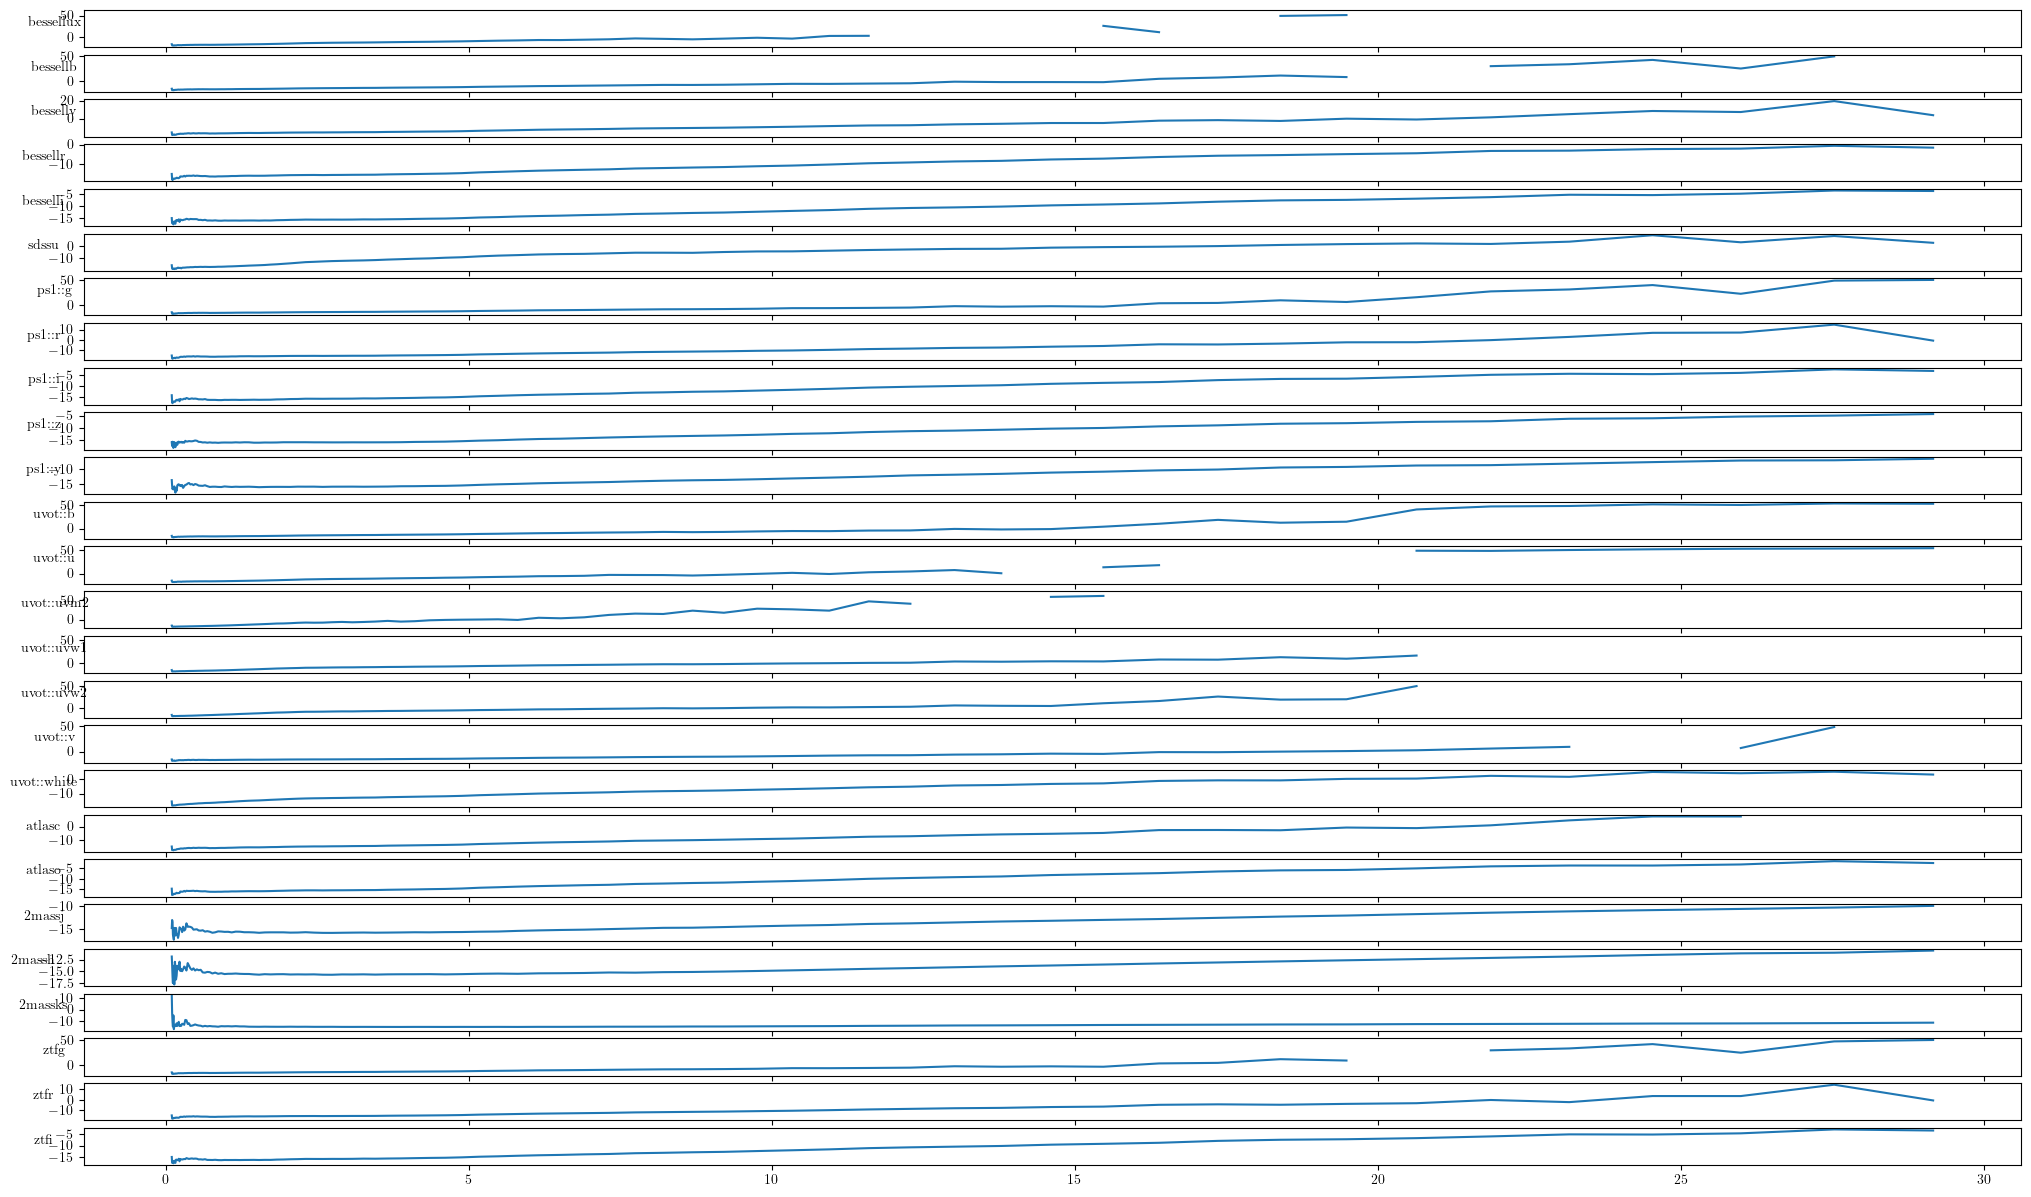

In [5]:
nrow = len(value_columns)
plt.subplots(nrow, 1, figsize=(25, 15), sharex = True)
t = dat["t"].values

for i, key in enumerate(value_columns):
    plt.subplot(nrow, 1, i+1)
    plt.plot(t, dat[key].values)
    plt.ylabel(key, rotation=0)
    plt.grid()
plt.show()

Have to get the parameters out with NMMA. To read and process a bunch of photometry files as the above directory, use the `read_photometry_files` function from NMMA from the `io` script. This creates a dictionary with keys being the filenames of youyr lightcurves, and values being the above Pandas dataframe as dictionary. **Note:** This can take a while if you have a large grid.

In [6]:
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans

In [7]:
data = read_photometry_files(full_filenames)

In [8]:
# Interpolate nans
data = interpolate_nans(data)

In order to process the data, NMMA needs to know which kind of data file you are using. This is needed in order to extract the parameters out of the filenames. In `model_parameters`, there is an overview of which lightcurves are supported for extracting the parameters:

In [9]:
import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
MODEL_FUNCTIONS

{'get_knprops_from_LANLfilename': <function nmma.em.utils.get_knprops_from_LANLfilename(filename)>,
 'AnBa2022_linear': <function nmma.em.model_parameters.AnBa2022_linear(data)>,
 'AnBa2022_log': <function nmma.em.model_parameters.AnBa2022_log(data)>,
 'AnBa2022_sparse': <function nmma.em.model_parameters.AnBa2022_sparse(data)>,
 'CV': <function nmma.em.model_parameters.CV(data)>,
 'Bu2019lm_sparse': <function nmma.em.model_parameters.Bu2019lm_sparse(data)>,
 'Bu2019lm': <function nmma.em.model_parameters.Bu2019lm(data)>,
 'Bu2019nsbh': <function nmma.em.model_parameters.Bu2019nsbh(data)>,
 'Bu2022Ye': <function nmma.em.model_parameters.Bu2022Ye(data)>,
 'Ka2017': <function nmma.em.model_parameters.Ka2017(data)>,
 'LANL2022': <function nmma.em.model_parameters.LANL2022(data)>}

We are using `Bu2022Ye`, so get the function to extract its parameters:

In [10]:
model_name = "Bu2022Ye"
model_function = MODEL_FUNCTIONS[model_name]

Then, preprocess the data into training data with parameters

In [11]:
training_data, parameters = model_function(data)

In [12]:
# training_data

In [13]:
parameters

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']

Get the filters that are used (by default, NMMA will use all available filters, which can be found as follows:)

In [14]:
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))
print(filts)

['2massh', '2massj', '2massks', 'atlasc', 'atlaso', 'bessellb', 'besselli', 'bessellr', 'bessellux', 'bessellv', 'ps1__g', 'ps1__i', 'ps1__r', 'ps1__y', 'ps1__z', 'sdssu', 'uvot__b', 'uvot__u', 'uvot__uvm2', 'uvot__uvw1', 'uvot__uvw2', 'uvot__v', 'uvot__white', 'ztfg', 'ztfi', 'ztfr']


## Getting the SVD model

Interpolation is done with an `SVDTrainingModel` object. Note that the initialization function immediately calls `interpolate_data` and starts training the model. 

In [15]:
from nmma.em.training import SVDTrainingModel

In [16]:
svd_ncoeff = 10

training_model = SVDTrainingModel(
        model_name,
        training_data,
        parameters,
        t,
        filts,
        n_coeff=svd_ncoeff,
        interpolation_type="tensorflow",
        start_training=False # don't train, just prep the data
    )

The grid will be interpolated to sample_time with interp1d


Now, we generate the SVD model

**TO DO** figure out what this does precisely

In [17]:
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model

Normalizing mag filter 2massh...
Normalizing mag filter 2massj...
Normalizing mag filter 2massks...
Normalizing mag filter atlasc...
Normalizing mag filter atlaso...
Normalizing mag filter bessellb...
Normalizing mag filter besselli...
Normalizing mag filter bessellr...
Normalizing mag filter bessellux...
Normalizing mag filter bessellv...
Normalizing mag filter ps1__g...
Normalizing mag filter ps1__i...
Normalizing mag filter ps1__r...
Normalizing mag filter ps1__y...
Normalizing mag filter ps1__z...
Normalizing mag filter sdssu...
Normalizing mag filter uvot__b...
Normalizing mag filter uvot__u...
Normalizing mag filter uvot__uvm2...
Normalizing mag filter uvot__uvw1...
Normalizing mag filter uvot__uvw2...
Normalizing mag filter uvot__v...
Normalizing mag filter uvot__white...
Normalizing mag filter ztfg...
Normalizing mag filter ztfi...
Normalizing mag filter ztfr...


### Exploring the data

Have a look at the SVD model:

In [18]:
training_model.svd_model['2massh'].keys()

dict_keys(['param_array_postprocess', 'param_mins', 'param_maxs', 'data_postprocess', 'mins', 'maxs', 'tt', 'n_coeff', 'cAmat', 'cAstd', 'VA'])

In [19]:
training_model.svd_model['2massj']

{'param_array_postprocess': array([[0.53724357, 0.        , 1.        , 0.62747356, 0.        ,
         0.28711111],
        [0.53724357, 0.        , 1.        , 1.        , 1.        ,
         0.66666667],
        [0.53724357, 0.        , 1.        , 0.85663468, 0.16666667,
         0.806     ],
        ...,
        [0.        , 0.61538462, 0.33333333, 0.85663468, 0.        ,
         0.50633333],
        [0.        , 0.        , 0.66666667, 0.        , 0.16666667,
         0.        ],
        [0.        , 0.23076923, 0.        , 0.        , 0.        ,
         0.28711111]]),
 'param_mins': array([-3.  ,  0.12,  0.15, -2.  ,  0.03,  0.  ]),
 'param_maxs': array([-1.69897   ,  0.25      ,  0.3       , -0.88605665,  0.15      ,
        90.        ]),
 'data_postprocess': array([[0.15895301, 0.19126668, 0.20292595, ..., 0.18128384, 0.21749341,
         0.25376811],
        [0.23215023, 0.14820101, 0.16322494, ..., 0.17779641, 0.21528576,
         0.25252288],
        [0.15349305, 0.0

Check out how a specific filter looks like:

In [20]:
svd_model = training_model.svd_model
example = svd_model['2massh']
list(example.keys())

['param_array_postprocess',
 'param_mins',
 'param_maxs',
 'data_postprocess',
 'mins',
 'maxs',
 'tt',
 'n_coeff',
 'cAmat',
 'cAstd',
 'VA']

In [21]:
print(training_model.model_parameters)
example['param_array_postprocess'][:3]

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']


array([[0.53724357, 0.        , 1.        , 0.62747356, 0.        ,
        0.28711111],
       [0.53724357, 0.        , 1.        , 1.        , 1.        ,
        0.66666667],
       [0.53724357, 0.        , 1.        , 0.85663468, 0.16666667,
        0.806     ]])

In [22]:
print(example['cAmat'].shape)

(10, 7700)


In [23]:
training_model.data['nph1.0e+06_dyn0.005-0.12-0.30_wind0.050-0.03_theta25.84_dMpc0']['data']


array([[-11.856     , -14.788     ,  12.727     , ..., -15.223     ,
        -14.911     , -14.879     ],
       [-13.678     , -13.012     ,  -3.248     , ..., -18.047     ,
        -17.417     , -17.902     ],
       [-16.154     , -13.518     , -11.411     , ..., -17.893     ,
        -17.301     , -17.696     ],
       ...,
       [-11.054     , -10.265     , -12.045     , ...,  47.556     ,
         -3.027     ,  14.391     ],
       [-10.604     ,  -9.888     , -11.653     , ...,  50.387     ,
         -3.504     ,  -0.605     ],
       [-10.12697794,  -9.48836152, -11.23746078, ...,  53.38799877,
         -4.00964338, -16.5014951 ]])

In [24]:
training_model.__dict__.keys()

dict_keys(['model', 'data', 'model_parameters', 'sample_times', 'filters', 'n_coeff', 'n_epochs', 'interpolation_type', 'data_type', 'data_time_unit', 'plot', 'plotdir', 'ncpus', 'univariate_spline', 'univariate_spline_s', 'random_seed', 'svd_path', 'svd_model'])

In [25]:
t = training_model.sample_times
for filt in training_model.filters:
    print(training_model.svd_model[filt]['cAmat'].shape)
    print(training_model.svd_model[filt]['param_array_postprocess'].shape)

(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)
(10, 7700)
(7700, 6)


In [26]:
training_model.filters

['2massh',
 '2massj',
 '2massks',
 'atlasc',
 'atlaso',
 'bessellb',
 'besselli',
 'bessellr',
 'bessellux',
 'bessellv',
 'ps1__g',
 'ps1__i',
 'ps1__r',
 'ps1__y',
 'ps1__z',
 'sdssu',
 'uvot__b',
 'uvot__u',
 'uvot__uvm2',
 'uvot__uvw1',
 'uvot__uvw2',
 'uvot__v',
 'uvot__white',
 'ztfg',
 'ztfi',
 'ztfr']

In [27]:
t

array([ 0.103,  0.109,  0.116,  0.122,  0.13 ,  0.137,  0.145,  0.154,
        0.163,  0.173,  0.183,  0.194,  0.206,  0.218,  0.231,  0.244,
        0.259,  0.274,  0.29 ,  0.308,  0.326,  0.345,  0.366,  0.387,
        0.41 ,  0.435,  0.461,  0.488,  0.517,  0.547,  0.58 ,  0.614,
        0.651,  0.689,  0.73 ,  0.773,  0.819,  0.868,  0.919,  0.974,
        1.032,  1.093,  1.158,  1.226,  1.299,  1.376,  1.458,  1.544,
        1.636,  1.733,  1.836,  1.944,  2.06 ,  2.182,  2.311,  2.448,
        2.594,  2.747,  2.91 ,  3.083,  3.266,  3.459,  3.665,  3.882,
        4.112,  4.356,  4.614,  4.888,  5.178,  5.485,  5.81 ,  6.155,
        6.52 ,  6.906,  7.316,  7.75 ,  8.21 ,  8.696,  9.212,  9.759,
       10.337, 10.95 , 11.6  , 12.288, 13.016, 13.788, 14.606, 15.472,
       16.39 , 17.362, 18.392, 19.482, 20.638, 21.862, 23.158, 24.532,
       25.987, 27.528, 29.16 , 30.89 ])

## Training a neural network using JAX

**Note:** I have defined my own Python script called `flax_utils` for auxiliary functions to implement training of FLAX models, since it requires more work than Tensorflow models (user have to define training loop themselves etc).

In [28]:
from sklearn.model_selection import train_test_split
from flax_utils import *

In [29]:
import clu as clu
import ml_collections
# from clu import metrics as metrics # this gives an import error

### Prepare the data

**TODO** Get dataloader etc from tensorflow? 

Let us train on the data of the first filter for simplicity for now:

In [30]:
X = training_model.svd_model[filts[0]]['param_array_postprocess']
n_samples, input_ndim = X.shape
print(f"Features have shape {X.shape}")
y = training_model.svd_model[filts[0]]['cAmat'].T
_, output_ndim = y.shape
print(f"Labels have shape {y.shape}")

Features have shape (7700, 6)
Labels have shape (7700, 10)


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

### Neural network architecture

Import the relevant jax and flax libraries:

In [32]:
import jax
import jax.numpy as jnp

from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses

# from clu import metrics
import optax

Define our initial PNRG key (see JAX gotchas to learn more about how JAX uses random number generators)

In [33]:
key = jax.random.PRNGKey(0)
# Split the random key to get a PRNG key for initialization of the network parameters
key, init_key = jax.random.split(key)

The hyperparameters are saved with the `ml_collections` package in a ConfigDict. We saved the default hyperparameters as follows:

In [34]:
config = get_default_config()
for (k, v) in config.items():
    if k == "my_scheduler":
        continue
    print(f"{k}: {v}")

act_func: <jax._src.custom_derivatives.custom_jvp object at 0x29a6ac4c0>
batch_size: 128
fixed_lr: False
layer_sizes: [64, 128, 64, 10]
learning_rate: 0.01
learning_rate_fn: None
name: MLP
nb_epochs: 1000
nb_epochs_decay: 100
nb_report: 100
optimizer: <function adam at 0x29aaa0820>


We have defined a simple custom scheduler for training. It has the following default hyperparameter values:

In [35]:
for (k, v) in config.my_scheduler.items():
    print(f"{k}: {v}")

counter: 0
history: 10
multiplier: 0.5
patience: 10
threshold: 0.995


We defined a new class for simplicity that implements MLPs of arbitrary sizes and with an arbitrary activation function that is applied at all hidden layers (*not* the output layer). The class is implemented in my own script `flax_training` and is simply called `MLP`. We initialize a new MLP object and print its architecture to the screen. 

In [36]:
net = MLP(layer_sizes = config.layer_sizes, act_func = config.act_func)
print(net.tabulate(jax.random.PRNGKey(0), jnp.ones(input_ndim)))


                                 MLP Summary                                 
┏━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module ┃ inputs       ┃ outputs      ┃ params                  ┃
┡━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          │ MLP    │ float32[6]   │ float32[10]  │                         │
├──────────┼────────┼──────────────┼──────────────┼─────────────────────────┤
│ layers_0 │ Dense  │ float32[6]   │ float32[64]  │ bias: float32[64]       │
│          │        │              │              │ kernel: float32[6,64]   │
│          │        │              │              │                         │
│          │        │              │              │ 448 (1.8 KB)            │
├──────────┼────────┼──────────────┼──────────────┼─────────────────────────┤
│ layers_1 │ Dense  │ float32[64]  │ float32[128] │ bias: float32[128]      │
│          │        │              │              │ kernel: flo

### Optimizers

Define the learning rate scheduler (see [these docs](https://optax.readthedocs.io/en/latest/api.html#optimizer-schedules) for more information)

**TODO** Implement scheduler based on loss history?

Implement the training loop for a step and an epoch:

Get the optimizer ready and create `TrainState` object, which is used for holding the parameters and updating them. Note: `TrainState` saves the optimizer under the field `tx`

In [37]:
state = create_train_state(net, jnp.ones(input_ndim), init_key, config)

In [38]:
state.tx # optimizer info

GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x29ea4c670>, update=<function chain.<locals>.update_fn at 0x29ea4cb80>)

Small example: we can get the parameter shapes as follows:

In [39]:
param_shapes = jax.tree_util.tree_map(lambda x: x.shape, state.params) # Checking output shapes
print(param_shapes)

FrozenDict({
    layers_0: {
        bias: (64,),
        kernel: (6, 64),
    },
    layers_1: {
        bias: (128,),
        kernel: (64, 128),
    },
    layers_2: {
        bias: (64,),
        kernel: (128, 64),
    },
    layers_3: {
        bias: (10,),
        kernel: (64, 10),
    },
})


### Training

The loss function will be MSE. **TODO** make this part as input?

In [40]:
end_state, train_losses, val_losses = train_loop(state, X_train, y_train, X_val, y_val, config)

Train loss at step 1: 8.595948219299316
Valid loss at step 1: 8.466808319091797
Learning rate: 0.01
---
Train loss at step 101: 0.08192899078130722
Valid loss at step 101: 0.07334102690219879
Learning rate: 0.01
---
Train loss at step 201: 0.05797664076089859
Valid loss at step 201: 0.04980911687016487
Learning rate: 0.01
---
Train loss at step 301: 0.04227406159043312
Valid loss at step 301: 0.034657735377550125
Learning rate: 0.01
---
Train loss at step 401: 0.05601518973708153
Valid loss at step 401: 0.04851855710148811
Learning rate: 0.01
---
Train loss at step 501: 0.03606181964278221
Valid loss at step 501: 0.028345763683319092
Learning rate: 0.01
---
Train loss at step 601: 0.03226868435740471
Valid loss at step 601: 0.024433109909296036
Learning rate: 0.01
---
Train loss at step 701: 0.03085939772427082
Valid loss at step 701: 0.022843660786747932
Learning rate: 0.01
---
Train loss at step 801: 0.030182480812072754
Valid loss at step 801: 0.022041747346520424
Learning rate: 0.0

Show the training progress:

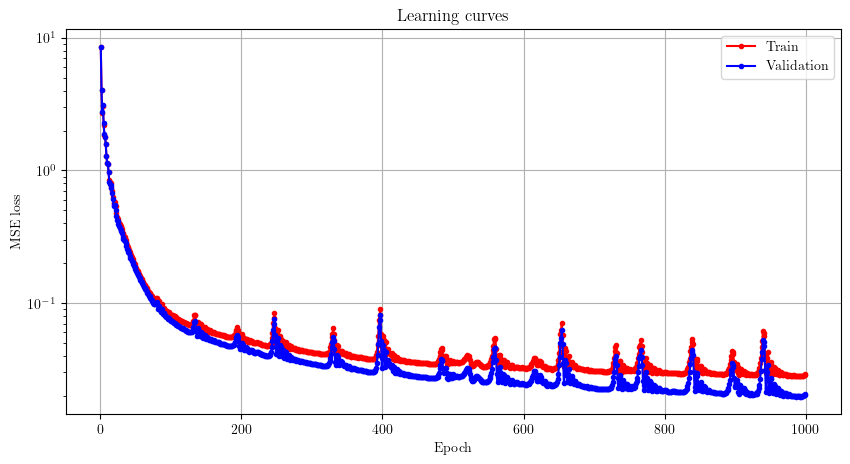

In [41]:
plt.figure(figsize = (10, 5))
start = 0
end = -1
ls = "-o"
ms = 3
plt.plot([i+1 for i in range(len(train_losses))][start:end], train_losses[start:end], ls, markersize = ms, label = "Train", color = "red")
plt.plot([i+1 for i in range(len(val_losses))][start:end], val_losses[start:end], ls, markersize = ms, label = "Validation", color = "blue")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.yscale('log')
plt.title("Learning curves")
plt.show()

**Discussion:** These learning curves look good. I am not sure why validation loss is lower than training loss, but this can happen sometimes and is not a reason for panic afaik. As can be seen from the loss, the learning rate is quite high after around 200 epochs and ideally should be adapted later on in the training. Future work should implement such learning rate schedulers such that the network can be trained towards lower loss values. Currently, this is not too much of an issue if we use the Adam optimizer: we see that the envelope of the loss curve is still decreasing.   

## Benchmarking surrogate models

**TODO:** We need a way to benchmark the surrogate models. For instance, we can check the MSE on the lightcurve rather than the SVD data, and compare this value for different surrogate models on a validation set of such lightcurves. This will allow us to finetune the architecture or to compare completely different approaches (GPR vs NN for instance).

## Extra: Exploring the data as pictures

**Idea/question:** Instead of using the SVD, could we perhaps train directly on the lightcurve data, *and* at the same time learn all the filters, instead of a single neural network for every single filter independently? (The latter approach does not capture relations between the different filters.) The idea would be to train a CNN architecture that generates images such as the one below if given the merger parameters. 

(7700, 100)
(26, 100)


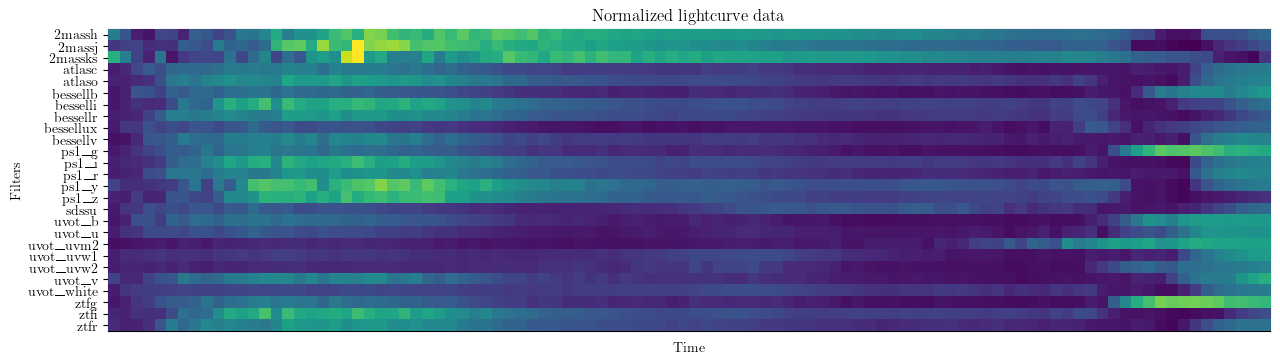

In [42]:
# Get the data
print(training_model.svd_model[filts[0]]['data_postprocess'].shape)
example_data = np.stack([training_model.svd_model[f]['data_postprocess'][0] for f in training_model.filters])
print(example_data.shape)

# Plot the data
no_ticks = False

plt.figure(figsize = (15, 12))
plt.imshow(example_data, zorder = 10)
# Labels
plt.xlabel("Time")
plt.ylabel("Filters")
# cbar = plt.colorbar()
# cbar.set_label("Normalized LC values")
plt.title("Normalized lightcurve data")
plt.xticks([])
plt.yticks([i for i in range(len(filts))], filts)
plt.show()

In [43]:
training_model.svd_model[filts[0]]['cAmat'].T[0]

array([-4.62778572, -0.36531729,  0.25260386, -0.06618868,  0.33647734,
        0.22141482,  0.00837703,  0.02129562,  0.01703494, -0.02540689])

Can also do the same idea with the SVD embedding. However, not sure how informative this is going to be...

In [44]:
# # Get the data
# example_data = np.stack([training_model.svd_model[f]['cAmat'].T[0] for f in training_model.filters])
# print(example_data.shape)

# # Plot the data
# no_ticks = False

# plt.figure(figsize = (15, 12))
# plt.imshow(example_data, zorder = 10)
# # Labels
# plt.xlabel("Time")
# plt.ylabel("Filters")
# # cbar = plt.colorbar()
# # cbar.set_label("Normalized LC values")
# plt.title("Embeddings")
# plt.xticks([])
# plt.yticks([i for i in range(len(filts))], filts)
# plt.show()

## Extra: Investigating PCA

**Idea/question:** The SVD uses 10 components by default. Is this good? Check the PCA as function of number of coefficients. *Edit:* Seems OK, not much to be improved here.

In [45]:
from sklearn.decomposition import PCA

In [46]:
training_model.svd_model['2massh']['data_postprocess'].shape

(7700, 100)

In [47]:
n_components = 0.95
pca = PCA(n_components = n_components)
pca.fit(training_model.svd_model['2massh']['data_postprocess'])
print(pca.n_components_)

14


In [48]:
pca.__dict__.keys()

dict_keys(['n_components', 'copy', 'whiten', 'svd_solver', 'tol', 'iterated_power', 'n_oversamples', 'power_iteration_normalizer', 'random_state', 'n_features_in_', '_fit_svd_solver', 'mean_', 'noise_variance_', 'n_samples_', 'n_features_', 'components_', 'n_components_', 'explained_variance_', 'explained_variance_ratio_', 'singular_values_'])

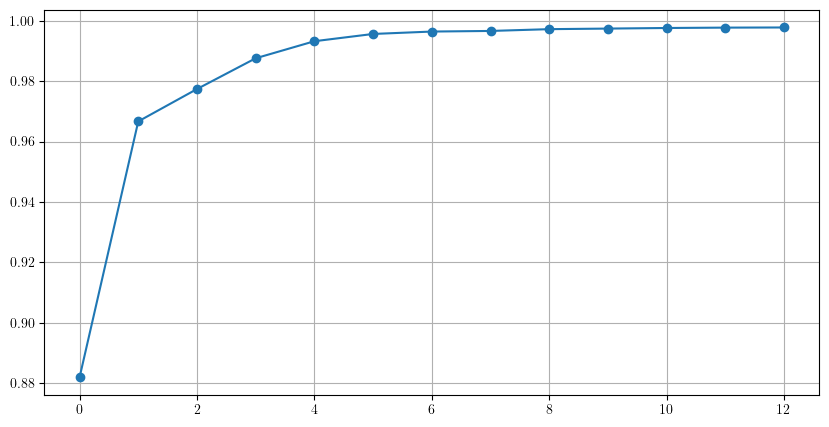

In [49]:
ratio = 1 - pca.explained_variance_ / np.cumsum(pca.explained_variance_)
ratio = 1 - pca.explained_variance_ratio_
plt.figure(figsize = (10, 5))
plt.plot(ratio[1:], '-o')
plt.show()